# Keras EfficientNetB0 Transferlearning

## Lod packages

In [1]:
import io
import os
import cv2
import random
import string
import shutil
import pathlib
import itertools
import math
import shap

In [2]:
from platform import python_version
print(python_version())

3.8.13


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [4]:
from tensorflow import keras
from sklearn import metrics
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from helper_functions import image_plot,ds_to_array,get_augmenter,plot_confusion_matrix

In [5]:
print("Keras Version : {}".format(keras.__version__))

print("SHAP Version : {}".format(shap.__version__))

print("Tensorflow Version : {}".format(tf.__version__))

Keras Version : 2.8.0
SHAP Version : 0.40.0
Tensorflow Version : 2.8.0


## Define paths

In [6]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
data_path               = os.path.join(parent_path, "01-Datasets/data/images")
model_path_parent       = os.path.join(parent_path, "04-Models/")
tensorboard_path_parent = os.path.join(parent_path, "03-Logs/03-Task3")

## Hyperparameters

In [7]:
model_name      = "b0tfl"
img_size        = 224
epochs          = 100  
learning_rate   = 1e-3
batch_size      = 32
steps_per_epoch = 100

## Load Data

In [8]:
# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
    with tf.device("/cpu:0"):
        img = tf.cast(img, dtype="int32")
        img = tf.image.resize_with_pad(img, img_size, img_size)
        return img, label
    
    
# Reading the data oldschool like
data = []
label = []
Files = ['no', 'yes']
label_val = 0

for files in Files:
    cpath = os.path.join(data_path, files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        image_array,_ = resize(image_array,label_val)
        data.append(image_array)
        label.append(label_val)
    label_val = 1
data = np.array(data)
label = np.asarray(label)
######---- MANY DUPLICATE WITHIN THE DATASET------######
# We recognized this after the report was written, with those two lines the identical dobulicates can be removed, but there are many
# more taht are a bit rotated or resized etc, which cannnot be easily removed.

# data,index = np.unique(data,axis=0,return_index=True)
# label = label[index]


#Split only into train and test test, since relatively low sample number splitting into train,val,test would result in
#to little sample number to make reasonable evaluations of the model...
#Also we are not doing hyperparameter tuning, therefore no overfitting on the validation set
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Transform to tf dataset for simplifing usage
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_test,Y_test))
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .batch(batch_size)
)

train_ds = train_ds.repeat()
background,lbls = X_test,Y_test

## Callbacks

In [9]:
tensorboard_path = os.path.join(tensorboard_path_parent, model_name)
try:
    shutil.rmtree(tensorboard_path)
except:
    pass    
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode ="max",
    patience=5,
    restore_best_weights=True,
)
tc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(background)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(lbls, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    classes=["No","Yes"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
    
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks = [es,tc,cm_callback]

## EffNetB0 Transferlearning

In [10]:
from tensorflow.keras.applications import EfficientNetB0
classification_augmentation = {"min_area": 0.5, "brightness": 0.3, "jitter": 0.1}
inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3))
x = get_augmenter(**classification_augmentation)(inputs)
base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
base_model.trainable = False
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)


model = tf.keras.Model(inputs, outputs, name="EfficientNet")    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

## Train Model

In [11]:
tf.keras.backend.clear_session()
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch)

Epoch 1/100
100/100 [==============================] - 18s 68ms/step - loss: 0.3524 - accuracy: 0.8458 - val_loss: 0.4264 - val_accuracy: 0.8571
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.1947 - accuracy: 0.9269 - val_loss: 0.3594 - val_accuracy: 0.8571
Epoch 3/100
100/100 [==============================] - 4s 37ms/step - loss: 0.1638 - accuracy: 0.9379 - val_loss: 0.3114 - val_accuracy: 0.8571
Epoch 4/100
100/100 [==============================] - 4s 37ms/step - loss: 0.1379 - accuracy: 0.9473 - val_loss: 0.3211 - val_accuracy: 0.8571
Epoch 5/100
100/100 [==============================] - 4s 36ms/step - loss: 0.1228 - accuracy: 0.9555 - val_loss: 0.3169 - val_accuracy: 0.8571
Epoch 6/100
100/100 [==============================] - 4s 38ms/step - loss: 0.1147 - accuracy: 0.9606 - val_loss: 0.3452 - val_accuracy: 0.8571


## Model Evaluation

Test F1 score : 0.8582
Test ACC score : 0.8571
Confusion matrix, without normalization
[[21  2]
 [ 6 27]]


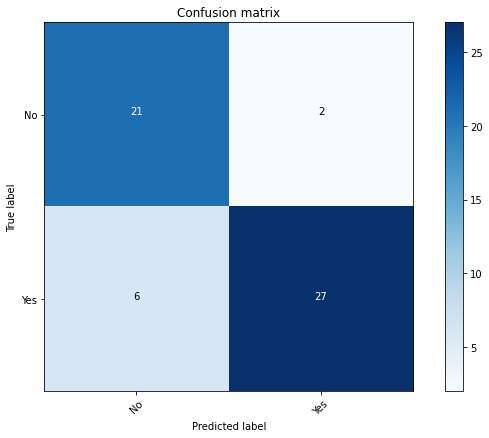

In [12]:
x,y = X_test,Y_test
y_pred = model.predict(x)
y_pred = (y_pred > 0.5).astype(np.int8)

f1 = f1_score(y, y_pred, average="weighted")
acc = accuracy_score(y, y_pred)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))


plot_confusion_matrix(y,y_pred,["No","Yes"])


## Post-hoc explanation with Shap Gradientexplainer and Explainer

## Gradient Explainer

In [13]:
lbls = lbls.reshape(lbls.shape[0], 1)
preds = model.predict(background)
preds = (preds > 0.5).astype(np.int8)
classes =  np.unique(lbls)
class_labels = ["No","Yes"]
mapping = dict(zip(classes, class_labels))
number = 5 # Number of images to show for false and true predicted

In [14]:
e = shap.GradientExplainer(model, background)

In [15]:
bol_predictions = preds==lbls
x_false = background[~bol_predictions.reshape(len(bol_predictions))]
y_false = lbls[~bol_predictions.reshape(len(bol_predictions))].reshape(len(x_false),1)
preds_false=preds[~bol_predictions.reshape(len(bol_predictions))].reshape(len(x_false),1)
shap_values_false = e.shap_values(x_false[0:number])

x_true = background[bol_predictions.reshape(len(bol_predictions))]
y_true = lbls[bol_predictions.reshape(len(bol_predictions))].reshape(len(x_true),1)
preds_true=preds[bol_predictions.reshape(len(bol_predictions))].reshape(len(x_true),1)
shap_values_true = e.shap_values(x_true[0:number])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


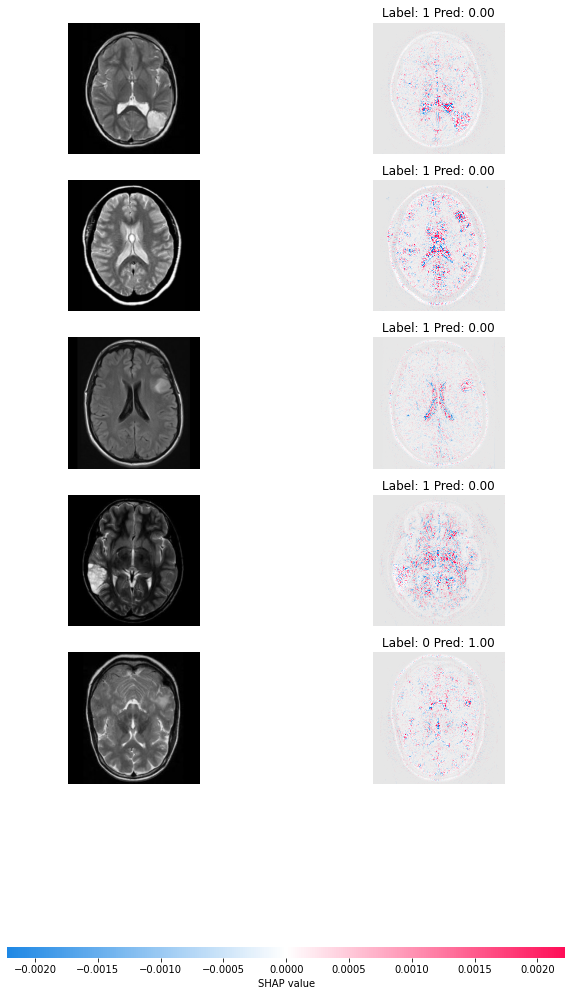

In [16]:
image_plot(shap_values_false, x_false[0:number], labels=y_false[0:number],preds=preds_false[0:number],fig_size=(10,20))

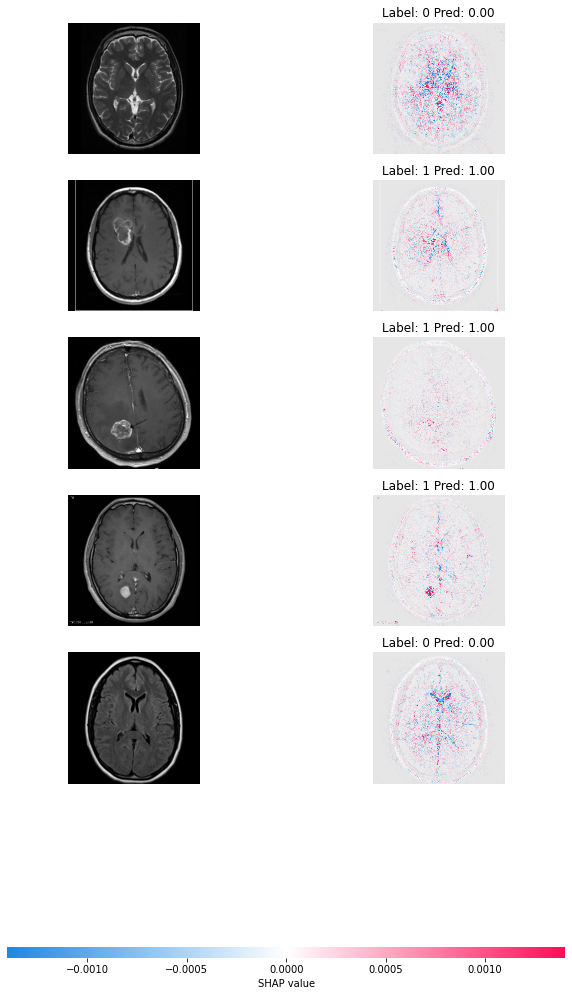

In [17]:
image_plot(shap_values_true, x_true[0:number], labels=y_true[0:number],preds=preds_true[0:number],fig_size=(10,20))

## Basic Explainer

In [18]:
def true_pred_label_string(true,preds):
    true = true.reshape(len(true))
    preds = preds.reshape(len(preds))
    tpls = ["True: "+class_labels[t]+"|| Pred: "+class_labels[p] for t,p in zip(true,preds)]
    return np.array(tpls).reshape(len(tpls),1)

In [19]:
masker = shap.maskers.Image("inpaint_telea", background[0].shape)
explainer = shap.Explainer(model, masker)
shap_values_false = explainer(x_false[0:number], max_evals=500, batch_size=20)

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  40%|████████████████████████████▍                                          | 2/5 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  4.94s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 6it [00:36,  9.17s/it]                                                                            


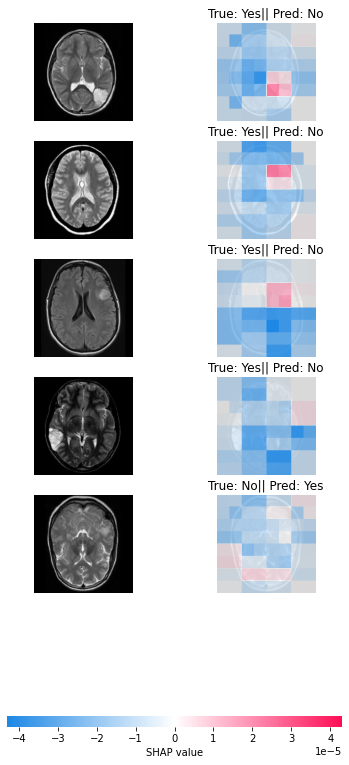

In [20]:
tpls_false = true_pred_label_string(y_false[0:number],preds_false[0:number])
shap.image_plot(shap_values_false,labels=tpls_false)

In [21]:
masker = shap.maskers.Image("inpaint_telea", background[0].shape)
explainer = shap.Explainer(model, masker)
shap_values_true = explainer(x_true[0:number], max_evals=500, batch_size=20)

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  40%|████████████████████████████▍                                          | 2/5 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.15s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 6it [00:40, 10.20s/it]                                                                            


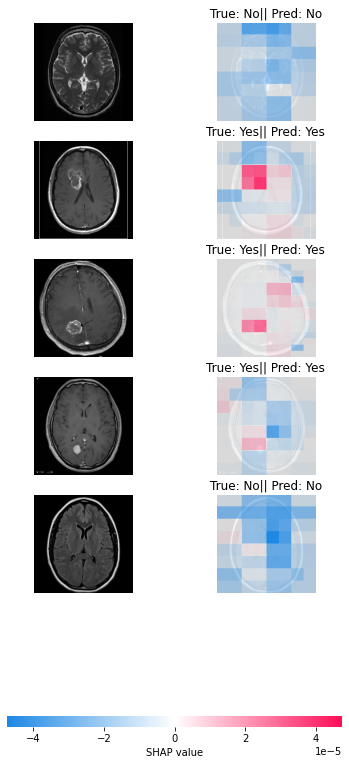

In [22]:
tpls_true = true_pred_label_string(y_true[0:number],preds_true[0:number])
shap.image_plot(shap_values_true,labels=tpls_true)

In [23]:
model_path = os.path.join(model_path_parent, model_name)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\Coding\ML4HC\03-Medical_Imaging\04-Models/b0tfl\assets


## Gradient Explainer of a specific Layer

In [24]:
# del tf,model
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# explain how the input to the 7th layer of the model explains the top two classes
model = tf.keras.models.load_model(model_path)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

Instructions for updating:
Colocations handled automatically by placer.


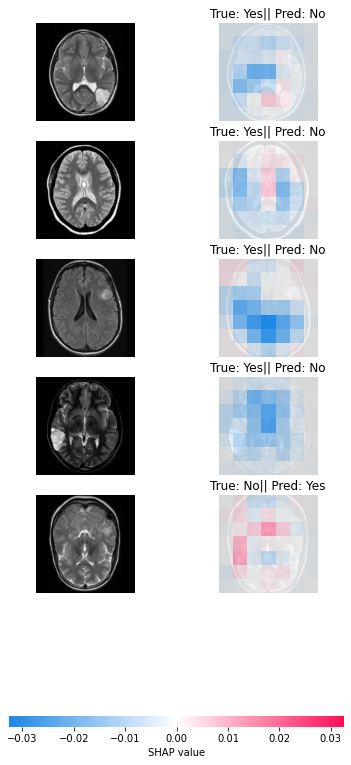

In [25]:
#Choose layer number, should be a conv2d layer (0-242 total layers)
layer_number = 236
e = shap.GradientExplainer((model.layers[layer_number].input, model.layers[-1].output), map2layer(background.copy(), layer_number))
shap_values,indexes = e.shap_values(map2layer(x_false[0:number], layer_number), ranked_outputs=1)

shap.image_plot(shap_values, x_false[0:number],tpls_false)


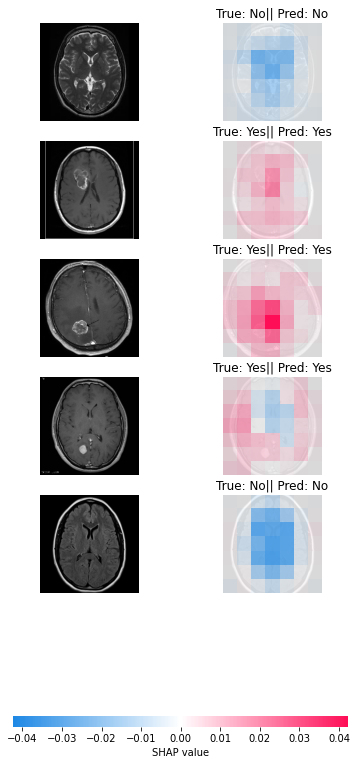

In [26]:
#Choose layer number, should be a conv2d layer (0-242 total layers)
layer_number = 236
e = shap.GradientExplainer((model.layers[layer_number].input, model.layers[-1].output), map2layer(background.copy(), layer_number))
shap_values,indexes = e.shap_values(map2layer(x_true[0:number], layer_number), ranked_outputs=1)

shap.image_plot(shap_values, x_true[0:number],tpls_true)

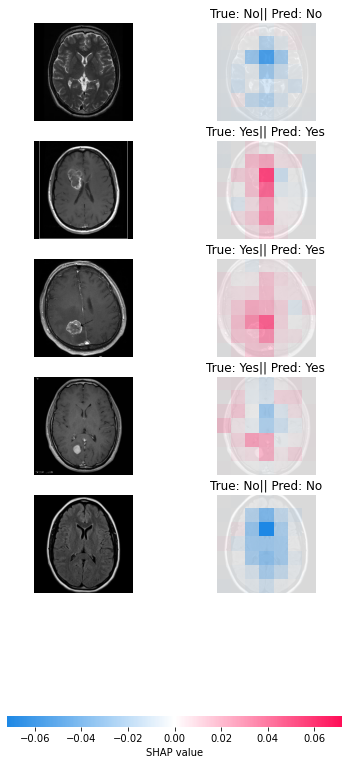

In [27]:
#Choose layer number, should be a conv2d layer (0-242 total layers)
layer_number = 192
e = shap.GradientExplainer((model.layers[layer_number].input, model.layers[-1].output), map2layer(background.copy(), layer_number))
shap_values,indexes = e.shap_values(map2layer(x_true[0:number], layer_number), ranked_outputs=1)

shap.image_plot(shap_values, x_true[0:number],tpls_true)

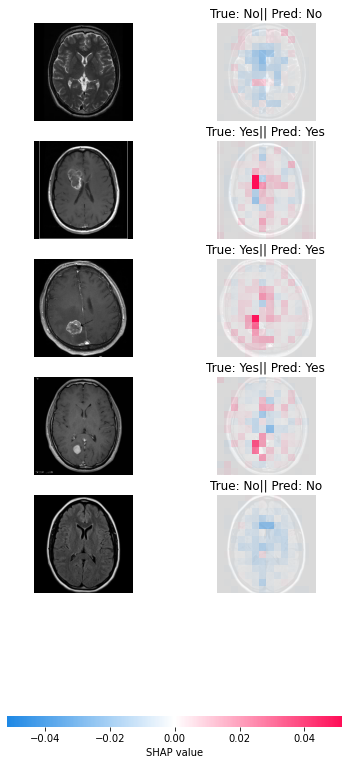

In [28]:
#Choose layer number, should be a conv2d layer (0-242 total layers)
layer_number = 122
e = shap.GradientExplainer((model.layers[layer_number].input, model.layers[-1].output), map2layer(background.copy(), layer_number))
shap_values,indexes = e.shap_values(map2layer(x_true[0:number], layer_number), ranked_outputs=1)

shap.image_plot(shap_values, x_true[0:number],tpls_true)

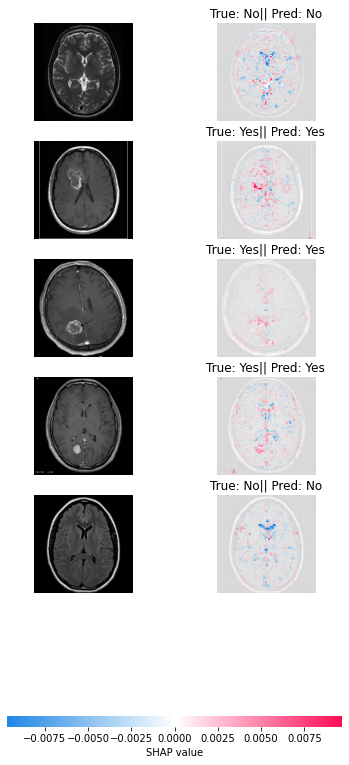

In [29]:
#Choose layer number, should be a conv2d layer (0-242 total layers)
layer_number = 32
e = shap.GradientExplainer((model.layers[layer_number].input, model.layers[-1].output), map2layer(background.copy(), layer_number))
shap_values,indexes = e.shap_values(map2layer(x_true[0:number], layer_number), ranked_outputs=1)

shap.image_plot(shap_values, x_true[0:number],tpls_true)